## AI Programming with Python Nanodegree: Image Classifier Project


In [3]:
# imports
import os
import requests
from pathlib import Path
import tarfile
import json
import torch
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
try:
    from torchinfo import summary
    from tqdm.autonotebook import tqdm
    from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
except:
    print("[INFO] Installing torchinfo for network architecture explanation.")
    !pip install torchinfo
    from torchinfo import summary
!pip install torchmetrics
from typing import Tuple
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from typing import Callable, Any
import functools
import time
import copy
from tqdm import tqdm

[INFO] Installing torchinfo for network architecture explanation.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.6 MB/s eta 0:00:00


In [4]:
# defining dataset directory
data_dir = './flowers'

# using pathlib.Path for handling PosixPath
FLOWERS_DIR = Path(data_dir)

# downloading and setting up data if not already present
if not FLOWERS_DIR.is_dir():
    # creating directory
    FLOWERS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Directory created: ./{FLOWERS_DIR}")

    print() # for readability

    # tarball path
    TARBALL = FLOWERS_DIR / "flower_data.tar.gz"

    # downloading and writing the tarball to './flowers' directory
    print(f"[INFO] Downloading the file 'flower_data.tar.gz' to ./{FLOWERS_DIR}")
    request = requests.get('https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz')
    with open(TARBALL, "wb") as file_ref:
        file_ref.write(request.content)
        print(f"[INFO] 'flower_data.tar.gz' saved to ./{FLOWERS_DIR}")

    print() # for readability

    # extracting the downloaded tarball
    print(f"[INFO] Extracting the downloaded tarball to ./{FLOWERS_DIR}")
    with tarfile.open(TARBALL, "r") as tar_ref:
        tar_ref.extractall(FLOWERS_DIR)
        print(f"[INFO] 'flower_data.tar.gz' extracted successfully to ./{FLOWERS_DIR}")

    print() # for readability

    # using os.remove to delete the downloaded tarball
    print("[INFO] Deleting the tarball to save space.")
    os.remove(TARBALL)
else:
    print(f"[INFO] Dataset already setup at ./{FLOWERS_DIR}")

[INFO] Directory created: ./flowers

[INFO] Downloading the file 'flower_data.tar.gz' to ./flowers
[INFO] 'flower_data.tar.gz' saved to ./flowers

[INFO] Extracting the downloaded tarball to ./flowers
[INFO] 'flower_data.tar.gz' extracted successfully to ./flowers

[INFO] Deleting the tarball to save space.


In [5]:
data = {
    "21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster",
    "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy",
    "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly",
    "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist",
    "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower",
    "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation",
    "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone",
    "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow",
    "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid",
    "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia",
    "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura",
    "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium",
    "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily",
    "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william",
    "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon",
    "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula",
    "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower",
    "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple",
    "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus",
    "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily",
    "46": "wallflower", "77": "passion flower", "51": "petunia"
}

with open('cat_to_name.json', 'w') as file:
    json.dump(data, file)

In [6]:
def manual_seed(random_seed: int = 42) -> None:
    '''
    For maintaining reproducibility of a notebook cell.
    '''
    # Set seed for generating random numbers on the CPU
    torch.manual_seed(random_seed)

    # Set seed for generating random numbers on the GPU if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

# Determine the device (GPU or CPU) to be used for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear the GPU cache if computation is performed on the GPU
if str(device) == "cuda":
    torch.cuda.empty_cache()


In [7]:
BATCH_SIZE = 32
LEARNING_RATE = 2e-4
EPOCHS = 15
HIDDEN_LAYER_1 = 256
HIDDEN_LAYER_2 = 128

In [8]:
resnet_34_weights = torchvision.models.ResNet34_Weights.DEFAULT
resnet_34_default_transforms = resnet_34_weights.transforms()
print(resnet_34_default_transforms)
model = torchvision.models.resnet34(weights = resnet_34_weights)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 123MB/s]


In [9]:
summary(model,
        input_size=(1,3,224,224),
        col_names=("input_size",
                   "output_size",
                   "num_params",
                   "kernel_size",
                   "mult_adds",
                   "trainable"),
        col_width=20,
        row_settings=("var_names",))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   --                   --                   True
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                [7, 7]               118,013,952          True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  --                   128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --                   --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   3                    --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --        

In [10]:
train_transforms = transforms.Compose([transforms.Resize(size=(256,256),
                                                         interpolation=transforms.InterpolationMode.BILINEAR),
                                       transforms.TrivialAugmentWide(interpolation = transforms.InterpolationMode.BILINEAR),
                                       transforms.CenterCrop(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

In [11]:
#datasets
train_dataset = torchvision.datasets.ImageFolder(root = str(FLOWERS_DIR / Path('train')),
                                        transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=str(FLOWERS_DIR / Path('valid')),
                                              transform=train_transforms)
CLASSES = train_dataset.classes
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = train_dataset.class_to_idx

In [12]:
#dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=os.cpu_count() if str(device) == "cuda" else 0,      # if you have GPU it makes sense to spin up multiple worker processes to fetch data batches, num_workers=<cpu cores> is a good rule of thumb (https://stackoverflow.com/a/54002191)
                                           pin_memory=True if str(device) == "cuda" else False)             # if you have GPU it almost always makes sense to have 'pin_memory = True', as this makes the data transfer to GPU more efficient (https://discuss.pytorch.org/t/when-to-set-pin-memory-to-true/19723/2)

# 2. validation set dataloader
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=os.cpu_count() if str(device) == "cuda" else 0,
                                         pin_memory=True if str(device) == "cuda" else False)

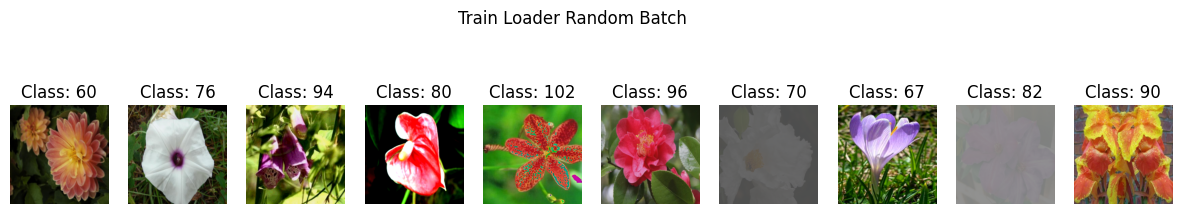

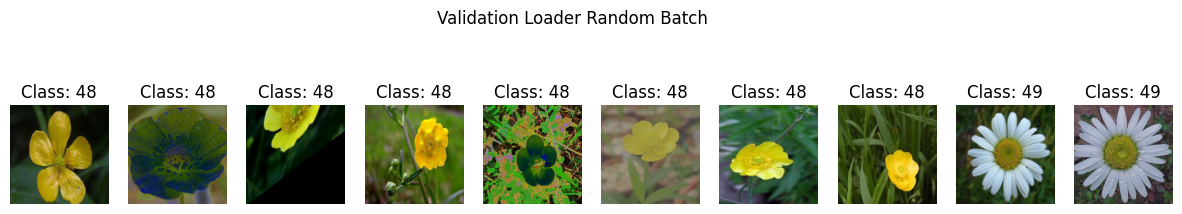

In [13]:
def denormalize_and_clip(img, mean, std):
    img = img.numpy(force=True) if isinstance(img, torch.Tensor) else img
    img = np.transpose(img, (1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img
def imshow(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
def visualize_random_batch(data_loader, loader_type, mean, std):
    batch_index = np.random.randint(len(data_loader))
    for i, (images, labels) in enumerate(data_loader):
        if i == batch_index:
            break
    classes = data_loader.dataset.classes
    num_images_to_show = min(10, len(images))#5
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
    for i in range(num_images_to_show):
        image = images[i]
        label = labels[i].item()
        class_name = classes[label]
        image = denormalize_and_clip(image, mean, std)
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')
    plt.suptitle(f'{loader_type} Random Batch')
    plt.show()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
visualize_random_batch(train_loader, 'Train Loader', mean, std)
visualize_random_batch(val_loader, 'Validation Loader', mean, std)

In [14]:
manual_seed()
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(nn.Linear(512, HIDDEN_LAYER_1),
                         nn.ReLU(),
                         nn.Dropout(p=0.2),
                         nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
                         nn.ReLU(),
                         nn.Dropout(p=0.2),
                         nn.Linear(HIDDEN_LAYER_2, len(train_dataset.classes)))

In [15]:
summary(model,
        input_size=(1,3,224,224),
        col_names=("input_size",
                   "output_size",
                   "num_params",
                   "kernel_size",
                   "mult_adds",
                   "trainable"),
        col_width=20,
        row_settings=("var_names",))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 102]             --                   --                   --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              [7, 7]               118,013,952          False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                --                   128                  False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --                   --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   3                    --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --   

In [16]:
def training_step(model: nn.Module,
                  train_dataloader: torch.utils.data.DataLoader,
                  optimizer: torch.optim.Optimizer,
                  criterion: nn.Module,
                  training_accuracy: MulticlassAccuracy,
                  training_f1: MulticlassF1Score,
                  epoch_num: int,
                  device: torch.device = device) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    model.train()
    epoch_loss = 0
    with tqdm(enumerate(train_dataloader, start=1), total=len(train_dataloader), unit=" train-batch") as tepoch:
        for batch_idx, (features, labels) in tepoch:
            tepoch.set_description(f"Epoch: {epoch_num+1} | Phase - Training")

            features, labels = features.to(device), labels.to(device).type(torch.long)
            logits = model(features)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.inference_mode():
                avg_loss_sample = loss/len(labels)
                batch_acc = training_accuracy.forward(logits, labels)
                batch_f1 = training_f1.forward(logits, labels)
            epoch_loss += avg_loss_sample
            tepoch.set_postfix(batch_f1_score=batch_f1.item(), batch_accuracy=f"{batch_acc.item()*100:.2f}%", loss_per_sample=avg_loss_sample.item())
    epoch_loss /= len(train_dataloader)
    print()
    print(f"[INFO] Epoch: {epoch_num+1} | loss: {epoch_loss.item():.3f} | training acc: {training_accuracy.compute().item()*100:.2f}% | training f1-score: {training_f1.compute().item():.2f}")
    return epoch_loss, training_accuracy.compute(), training_f1.compute()


In [17]:
def testing_step(model: nn.Module,
                 test_dataloader: torch.utils.data.DataLoader,
                 criterion: nn.Module,
                 test_accuracy: MulticlassAccuracy,
                 test_f1: MulticlassF1Score,
                 epoch_num: int = -1,
                 device: torch.device = device) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    model.eval()
    epoch_loss = 0
    with tqdm(enumerate(test_dataloader, start=1), total=len(test_dataloader), unit=" test-batch") as tepoch:
        for batch_idx, (features, labels) in tepoch:
            tepoch.set_description(f"Epoch: {epoch_num+1} | Phase - Validation/Test")
            features, labels = features.to(device), labels.to(device).type(torch.long)
            with torch.inference_mode():
                logits = model(features)
                loss = criterion(logits, labels)
                avg_loss_sample = loss/len(labels)
                batch_acc = test_accuracy.forward(logits, labels)
                batch_f1 = test_f1.forward(logits, labels)
            epoch_loss += avg_loss_sample
            tepoch.set_postfix(batch_f1_score=batch_f1.item(), batch_accuracy=f"{batch_acc.item()*100:.2f}%", loss_per_sample=avg_loss_sample.item())
    epoch_loss /= len(test_dataloader)
    print()
    print(f"[INFO] Epoch: {epoch_num+1} | loss: {epoch_loss.item():.3f} | val/test acc: {test_accuracy.compute().item()*100:.2f}% | val/test f1-score: {test_f1.compute().item():.2f}")
    print()
    return epoch_loss, test_accuracy.compute(), test_f1.compute()

In [18]:

def timing_function(func: Callable[..., Any]) -> Callable[..., Any]:
    @functools.wraps(func)
    def wrapper(*args, **kwargs) -> Any:
        start_time = time.perf_counter()
        func_out = func(*args, **kwargs)
        end_time = time.perf_counter()
        print()
        print()
        print(f"[INFO] Time taken -> {(end_time-start_time)//60}m and {(end_time-start_time)%60:.2f}s")
        return func_out
    return wrapper

In [19]:
@timing_function
def training(model: nn.Module,
             train_dataloader: torch.utils.data.DataLoader,
             test_dataloader: torch.utils.data.DataLoader,
             optimizer: torch.optim.Optimizer,
             criterion: nn.Module,
             training_accuracy: MulticlassAccuracy,
             training_f1: MulticlassF1Score,
             test_accuracy: MulticlassAccuracy,
             test_f1: MulticlassF1Score,
             epochs: int = 5,
             device: torch.device = device) -> Tuple[dict, dict]:
             model.to(device)
             training_accuracy.to(device)
             training_f1.to(device)
             test_accuracy.to(device)
             test_f1.to(device)
             train_loss = []
             train_acc = []
             train_f1 = []
             val_loss = []
             val_acc = []
             val_f1 = []
             best_loss = float("inf")
             for epoch_iter in range(epochs):
                train_epoch_loss, train_epoch_acc, train_epoch_f1 = training_step(model,
                                                                                  train_dataloader,
                                                                                  optimizer,
                                                                                  criterion,
                                                                                  training_accuracy,
                                                                                  training_f1,
                                                                                  epoch_iter,
                                                                                  device)
                train_loss.append(train_epoch_loss)
                train_acc.append(train_epoch_acc)
                train_f1.append(train_epoch_f1)
                print()
                val_epoch_loss, val_epoch_acc, val_epoch_f1 = testing_step(model,
                                                                           test_dataloader,
                                                                           criterion,
                                                                           test_accuracy,
                                                                           test_f1,
                                                                           epoch_iter,
                                                                           device)
                val_loss.append(val_epoch_loss)
                val_acc.append(val_epoch_acc)
                val_f1.append(val_epoch_f1)
                print()
                if best_loss > val_epoch_loss:
                    best_model = copy.deepcopy(model.state_dict())
                    best_loss = val_epoch_loss
                    best_epoch = epoch_iter
             train_loss = [tensor.item() for tensor in train_loss]
             train_acc = [tensor.item() for tensor in train_acc]
             train_f1 = [tensor.item() for tensor in train_f1]
             val_loss = [tensor.item() for tensor in val_loss]
             val_acc = [tensor.item() for tensor in val_acc]
             val_f1 = [tensor.item() for tensor in val_f1]
             training_statistics = {"training_loss": train_loss,
                                    "training_accuracy": train_acc,
                                    "training_f1": train_f1,
                                    "validation_loss": val_loss,
                                    "validation_accuracy": val_acc,
                                    "validation_f1": val_f1,
                                    "best_epoch": best_epoch+1,
                                    "loss_on_best_epoch": best_loss.item(),
                                    "device_used": device}
             print()
             print()
             print(f"Best epoch: {training_statistics['best_epoch']} | Training acc on best epoch: {training_statistics['training_accuracy'][training_statistics['best_epoch']-1]*100:.2f}% | Validation acc on best epoch: {training_statistics['validation_accuracy'][training_statistics['best_epoch']-1]*100:.2f}%")
             return best_model, training_statistics

In [20]:
def save_model(model: nn.Module,
               model_name: str) -> str:
    SAVE_PATH = f"./{model_name}.pt"
    torch.save(model.state_dict(), SAVE_PATH)
    print(f"[INFO] {model_name} saved to {SAVE_PATH}")
    return SAVE_PATH
def save_checkpoint(optimizer: torch.optim.Optimizer,
                    criterion: nn.Module,
                    epoch: int,
                    device_trained_on: torch.device,
                    hidden_layers: tuple,
                    output_layer: int,
                    classes: list,
                    class_to_idx: dict,
                    checkpoint_name: str = "checkpoint") -> str:
    SAVE_PATH = f"./{checkpoint_name}.pth"
    torch.save({"optimizer": optimizer.state_dict(),
                "criterion": criterion,
                "epoch": epoch,
                "device_trained_on": device_trained_on,
                "hidden_layers": hidden_layers,
                "output_layer": output_layer,
                "classes": classes,
                "class_to_idx": class_to_idx}, SAVE_PATH)
    print(f"[INFO] The general checkpoint has been saved to: {SAVE_PATH}")
    return SAVE_PATH
def load_model(model_save_path: str,
               hidden_layers: tuple,
               output_layer: int,
               device_trained_on: torch.device,
               device: torch.device) -> nn.Module:
    model = torchvision.models.resnet34(weights = None)
    model.fc = nn.Sequential(nn.Linear(512, hidden_layers[0]),
                             nn.ReLU(),
                             nn.Dropout(p=0.2),
                             nn.Linear(hidden_layers[0], hidden_layers[1]),
                             nn.ReLU(),
                             nn.Dropout(p=0.2),
                             nn.Linear(hidden_layers[1], output_layer))
    if str(device_trained_on) in ("cuda", "cuda:0"):
        if str(device) == "cpu":
            model.load_state_dict(torch.load(model_save_path, map_location=device))
        elif str(device) in ("cuda", "cuda:0"):
            model.load_state_dict(torch.load(model_save_path))
    else:
        if str(device) == "cpu":
            model.load_state_dict(torch.load(model_save_path))
        elif str(device) in ("cuda", "cuda:0"):
            model.load_state_dict(torch.load(model_save_path, map_location="cuda:0"))
    model.to(device);
    model.eval();
    return model
def load_checkpoint(checkpoint_save_path: str) -> dict:
    CHECKPOINT_DICT = torch.load(checkpoint_save_path)
    return CHECKPOINT_DICT

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.fc.parameters(),
                             lr = LEARNING_RATE)
training_acc = MulticlassAccuracy(num_classes = NUM_CLASSES)
training_f1 = MulticlassF1Score(num_classes = NUM_CLASSES)
val_acc = MulticlassAccuracy(num_classes = NUM_CLASSES)
val_f1 = MulticlassF1Score(num_classes = NUM_CLASSES)

In [22]:
# using manual_seed for reproducbility
manual_seed()

# starting training
resnet_state_dict, training_stats = training(model,
                                             train_dataloader = train_loader,
                                             test_dataloader = val_loader,
                                             optimizer = optimizer,
                                             criterion = criterion,
                                             training_accuracy = training_acc,
                                             training_f1 = training_f1,
                                             test_accuracy = val_acc,
                                             test_f1 = val_f1,
                                             epochs=EPOCHS)

Epoch: 1 | Phase - Training: 100%|██████████| 205/205 [00:51<00:00,  3.97 train-batch/s, batch_accuracy=3.70%, batch_f1_score=0.00823, loss_per_sample=0.183]


[INFO] Epoch: 1 | loss: 0.137 | training acc: 2.67% | training f1-score: 0.02




Epoch: 1 | Phase - Validation/Test: 100%|██████████| 26/26 [00:06<00:00,  4.20 test-batch/s, batch_accuracy=0.00%, batch_f1_score=0, loss_per_sample=0.238]


[INFO] Epoch: 1 | loss: 0.129 | val/test acc: 6.82% | val/test f1-score: 0.04





Epoch: 2 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.51 train-batch/s, batch_accuracy=22.73%, batch_f1_score=0.202, loss_per_sample=0.138]


[INFO] Epoch: 2 | loss: 0.113 | training acc: 6.92% | training f1-score: 0.06




Epoch: 2 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.50 test-batch/s, batch_accuracy=4.07%, batch_f1_score=0.0688, loss_per_sample=0.164]


[INFO] Epoch: 2 | loss: 0.094 | val/test acc: 15.63% | val/test f1-score: 0.14





Epoch: 3 | Phase - Training: 100%|██████████| 205/205 [00:46<00:00,  4.38 train-batch/s, batch_accuracy=39.42%, batch_f1_score=0.392, loss_per_sample=0.094]


[INFO] Epoch: 3 | loss: 0.088 | training acc: 12.49% | training f1-score: 0.12




Epoch: 3 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.91 test-batch/s, batch_accuracy=16.30%, batch_f1_score=0.214, loss_per_sample=0.129]


[INFO] Epoch: 3 | loss: 0.071 | val/test acc: 23.18% | val/test f1-score: 0.23





Epoch: 4 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.47 train-batch/s, batch_accuracy=48.28%, batch_f1_score=0.483, loss_per_sample=0.0811]


[INFO] Epoch: 4 | loss: 0.072 | training acc: 17.85% | training f1-score: 0.19




Epoch: 4 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.86 test-batch/s, batch_accuracy=20.83%, batch_f1_score=0.267, loss_per_sample=0.0973]


[INFO] Epoch: 4 | loss: 0.058 | val/test acc: 29.67% | val/test f1-score: 0.31





Epoch: 5 | Phase - Training: 100%|██████████| 205/205 [00:46<00:00,  4.44 train-batch/s, batch_accuracy=25.00%, batch_f1_score=0.255, loss_per_sample=0.0922]


[INFO] Epoch: 5 | loss: 0.062 | training acc: 22.81% | training f1-score: 0.24




Epoch: 5 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.82 test-batch/s, batch_accuracy=21.67%, batch_f1_score=0.248, loss_per_sample=0.111]


[INFO] Epoch: 5 | loss: 0.049 | val/test acc: 35.68% | val/test f1-score: 0.38





Epoch: 6 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.48 train-batch/s, batch_accuracy=60.00%, batch_f1_score=0.581, loss_per_sample=0.0545]



[INFO] Epoch: 6 | loss: 0.055 | training acc: 27.05% | training f1-score: 0.29



Epoch: 6 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.93 test-batch/s, batch_accuracy=35.56%, batch_f1_score=0.411, loss_per_sample=0.063]


[INFO] Epoch: 6 | loss: 0.042 | val/test acc: 40.00% | val/test f1-score: 0.43





Epoch: 7 | Phase - Training: 100%|██████████| 205/205 [00:46<00:00,  4.45 train-batch/s, batch_accuracy=73.08%, batch_f1_score=0.718, loss_per_sample=0.0421]


[INFO] Epoch: 7 | loss: 0.050 | training acc: 30.60% | training f1-score: 0.33




Epoch: 7 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.81 test-batch/s, batch_accuracy=28.75%, batch_f1_score=0.319, loss_per_sample=0.0978]


[INFO] Epoch: 7 | loss: 0.042 | val/test acc: 43.55% | val/test f1-score: 0.46





Epoch: 8 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.48 train-batch/s, batch_accuracy=50.00%, batch_f1_score=0.513, loss_per_sample=0.0473]


[INFO] Epoch: 8 | loss: 0.047 | training acc: 33.67% | training f1-score: 0.36




Epoch: 8 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.71 test-batch/s, batch_accuracy=43.89%, batch_f1_score=0.466, loss_per_sample=0.0665]


[INFO] Epoch: 8 | loss: 0.038 | val/test acc: 46.44% | val/test f1-score: 0.49





Epoch: 9 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.47 train-batch/s, batch_accuracy=48.00%, batch_f1_score=0.472, loss_per_sample=0.0507]


[INFO] Epoch: 9 | loss: 0.043 | training acc: 36.36% | training f1-score: 0.39




Epoch: 9 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.72 test-batch/s, batch_accuracy=46.67%, batch_f1_score=0.515, loss_per_sample=0.0475]


[INFO] Epoch: 9 | loss: 0.034 | val/test acc: 49.13% | val/test f1-score: 0.52





Epoch: 10 | Phase - Training: 100%|██████████| 205/205 [00:46<00:00,  4.40 train-batch/s, batch_accuracy=46.30%, batch_f1_score=0.469, loss_per_sample=0.0507]


[INFO] Epoch: 10 | loss: 0.041 | training acc: 38.81% | training f1-score: 0.41




Epoch: 10 | Phase - Validation/Test: 100%|██████████| 26/26 [00:05<00:00,  4.71 test-batch/s, batch_accuracy=54.67%, batch_f1_score=0.571, loss_per_sample=0.042]



[INFO] Epoch: 10 | loss: 0.033 | val/test acc: 51.35% | val/test f1-score: 0.54




Epoch: 11 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.47 train-batch/s, batch_accuracy=80.00%, batch_f1_score=0.787, loss_per_sample=0.0345]


[INFO] Epoch: 11 | loss: 0.038 | training acc: 41.03% | training f1-score: 0.44




Epoch: 11 | Phase - Validation/Test: 100%|██████████| 26/26 [00:06<00:00,  4.17 test-batch/s, batch_accuracy=70.83%, batch_f1_score=0.727, loss_per_sample=0.0363]



[INFO] Epoch: 11 | loss: 0.031 | val/test acc: 53.31% | val/test f1-score: 0.56




Epoch: 12 | Phase - Training: 100%|██████████| 205/205 [00:44<00:00,  4.57 train-batch/s, batch_accuracy=66.00%, batch_f1_score=0.667, loss_per_sample=0.0396]


[INFO] Epoch: 12 | loss: 0.037 | training acc: 43.00% | training f1-score: 0.46




Epoch: 12 | Phase - Validation/Test: 100%|██████████| 26/26 [00:06<00:00,  4.04 test-batch/s, batch_accuracy=70.83%, batch_f1_score=0.727, loss_per_sample=0.0328]


[INFO] Epoch: 12 | loss: 0.030 | val/test acc: 54.89% | val/test f1-score: 0.57





Epoch: 13 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.54 train-batch/s, batch_accuracy=73.91%, batch_f1_score=0.716, loss_per_sample=0.0373]



[INFO] Epoch: 13 | loss: 0.036 | training acc: 44.70% | training f1-score: 0.47



Epoch: 13 | Phase - Validation/Test: 100%|██████████| 26/26 [00:06<00:00,  4.07 test-batch/s, batch_accuracy=43.89%, batch_f1_score=0.466, loss_per_sample=0.0648]


[INFO] Epoch: 13 | loss: 0.028 | val/test acc: 56.48% | val/test f1-score: 0.59





Epoch: 14 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.54 train-batch/s, batch_accuracy=48.55%, batch_f1_score=0.462, loss_per_sample=0.0483]


[INFO] Epoch: 14 | loss: 0.034 | training acc: 46.31% | training f1-score: 0.49




Epoch: 14 | Phase - Validation/Test: 100%|██████████| 26/26 [00:06<00:00,  4.09 test-batch/s, batch_accuracy=43.89%, batch_f1_score=0.466, loss_per_sample=0.0563]


[INFO] Epoch: 14 | loss: 0.028 | val/test acc: 57.83% | val/test f1-score: 0.60





Epoch: 15 | Phase - Training: 100%|██████████| 205/205 [00:45<00:00,  4.54 train-batch/s, batch_accuracy=50.00%, batch_f1_score=0.488, loss_per_sample=0.0377]


[INFO] Epoch: 15 | loss: 0.033 | training acc: 47.69% | training f1-score: 0.50




Epoch: 15 | Phase - Validation/Test: 100%|██████████| 26/26 [00:06<00:00,  4.03 test-batch/s, batch_accuracy=54.67%, batch_f1_score=0.571, loss_per_sample=0.0362]


[INFO] Epoch: 15 | loss: 0.027 | val/test acc: 59.07% | val/test f1-score: 0.61




Best epoch: 15 | Training acc on best epoch: 47.69% | Validation acc on best epoch: 59.07%


[INFO] Time taken -> 13.0m and 1.64s


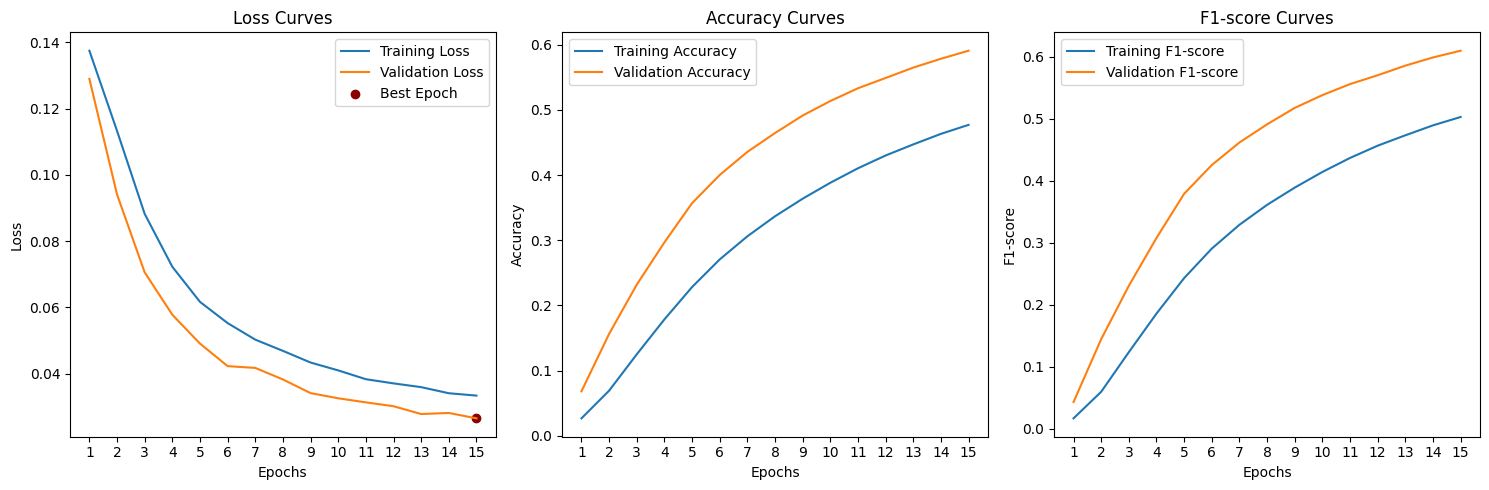

In [23]:
def plot_curves(stats):
    training_loss = stats['training_loss']
    training_accuracy = stats['training_accuracy']
    training_f1 = stats['training_f1']
    validation_loss = stats['validation_loss']
    validation_accuracy = stats['validation_accuracy']
    validation_f1 = stats['validation_f1']
    best_epoch = stats['best_epoch']
    loss_on_best_epoch = stats['loss_on_best_epoch']
    epochs = range(1, len(training_loss) + 1)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.scatter(best_epoch, loss_on_best_epoch, color='darkred', marker='o', label='Best Epoch')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(epochs, training_f1, label='Training F1-score')
    plt.plot(epochs, validation_f1, label='Validation F1-score')
    plt.title('F1-score Curves')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.xticks(epochs)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_curves(training_stats)

In [24]:
MODEL_SAVE_PATH = save_model(model, "resnet_34")
CHKPT_SAVE_PATH = save_checkpoint(optimizer,
                                  criterion,
                                  epoch = training_stats["best_epoch"]-1,
                                  device_trained_on = device,
                                  hidden_layers = (HIDDEN_LAYER_1, HIDDEN_LAYER_2),
                                  output_layer = NUM_CLASSES,
                                  classes = CLASSES,
                                  class_to_idx = CLASS_TO_IDX,
                                  checkpoint_name = "checkpoint")
CHKPT_DICT = load_checkpoint(CHKPT_SAVE_PATH)
new_model = load_model(MODEL_SAVE_PATH,
                       hidden_layers = CHKPT_DICT["hidden_layers"],
                       output_layer = CHKPT_DICT["output_layer"],
                       device_trained_on = CHKPT_DICT["device_trained_on"],
                       device = torch.device("cpu"))

[INFO] resnet_34 saved to ./resnet_34.pt
[INFO] The general checkpoint has been saved to: ./checkpoint.pth


--2024-02-07 07:37:38--  https://upload.wikimedia.org/wikipedia/commons/f/fd/Pink_flower.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190173 (186K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 185.72K  --.-KB/s    in 0.08s   

2024-02-07 07:37:39 (2.15 MB/s) - ‘image.jpg’ saved [190173/190173]



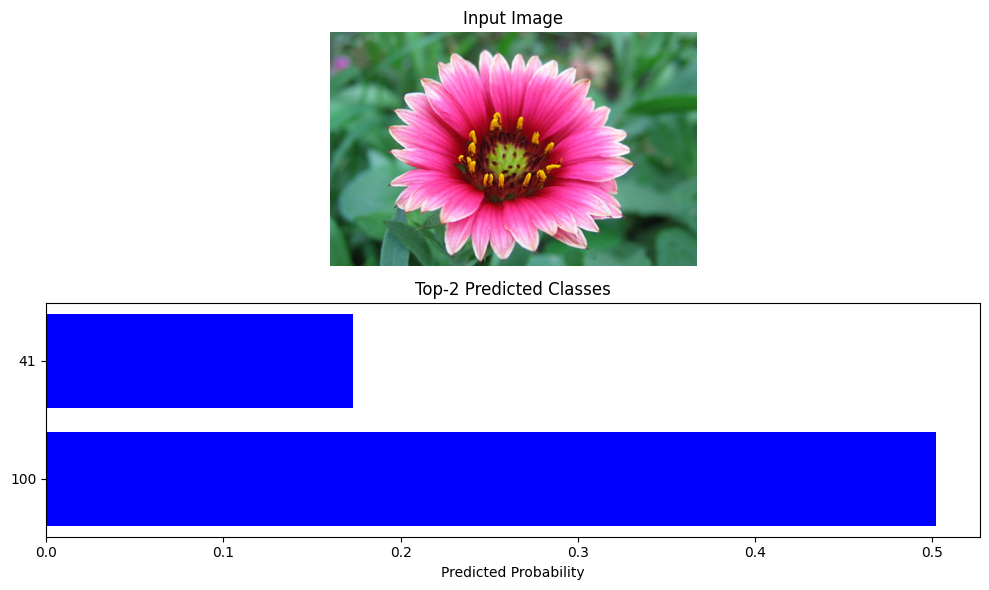



[INFO] Time taken -> 0.0m and 0.44s


In [25]:
@timing_function
def predict_and_plot_topk(model: nn.Module,
                          img_transform: transforms.Compose,
                          class_list: list,
                          image_path: str,
                          device: torch.device,
                          topk: int = 5):
    image = Image.open(image_path).convert("RGB")
    input_tensor = img_transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    topk_probs, topk_indices = torch.topk(probabilities, topk)
    topk_probs_np = topk_probs.numpy(force=True)
    topk_indices_np = topk_indices.numpy(force=True)
    probs_np = probabilities.numpy(force=True)
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')
    plt.subplot(2, 1, 2)
    plt.barh([class_list[i] for i in topk_indices_np], topk_probs_np, color='blue')
    plt.xlabel('Predicted Probability')
    plt.title(f'Top-{topk} Predicted Classes')
    plt.tight_layout()
    plt.show()
!wget https://upload.wikimedia.org/wikipedia/commons/f/fd/Pink_flower.jpg -O image.jpg
predict_and_plot_topk(new_model,
                      resnet_34_default_transforms,
                      CLASSES,
                      "image.jpg",
                      device,
                      topk=2)